In [1]:
import torch
import torch.nn as nn

import numpy as np

from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA


import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import random

### VAE architecture

In [2]:
class Encoder(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()

        self.FC_input = nn.Linear(input_dim, hidden_dim)
        self.FC_input2 = nn.Linear(hidden_dim, latent_dim)
        
        self.LeakyReLU = nn.LeakyReLU(0.2)
        
        self.training = True
        
    def forward(self, x):
        h_       = self.LeakyReLU(self.FC_input(x))
        latent   = self.LeakyReLU(self.FC_input2(h_))
        
        return latent

In [3]:
class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.FC_hidden = nn.Linear(latent_dim, hidden_dim)
        self.FC_hidden2 = nn.Linear(hidden_dim, hidden_dim)
        self.FC_output = nn.Linear(hidden_dim, output_dim)
        
        self.LeakyReLU = nn.LeakyReLU(0.2)
        
    def forward(self, x):
        h     = self.LeakyReLU(self.FC_hidden(x))
        h     = self.LeakyReLU(self.FC_hidden2(h))
        
        x_hat = self.FC_output(h)
        return x_hat
        

In [4]:
class Model(nn.Module):
    def __init__(self, Encoder, Decoder):
        super(Model, self).__init__()
        self.Encoder = Encoder
        self.Decoder = Decoder
                  
    def forward(self, x):
        latent = self.Encoder(x)
        x_hat  = self.Decoder(latent)
        
        return x_hat

In [ ]:
# Set seed for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

cuda = False
DEVICE = torch.device("cuda" if cuda else "cpu")

batch_size = 100

x_dim  = 11
hidden_dim = 7
latent_dim = 3

lr = 1e-3

epochs = 10#0

In [6]:
encoder = Encoder(input_dim=x_dim, hidden_dim=hidden_dim, latent_dim=latent_dim)
decoder = Decoder(latent_dim=latent_dim, hidden_dim = hidden_dim, output_dim = x_dim)

model = Model(Encoder=encoder, Decoder=decoder).to(DEVICE)

### Loss function

In [7]:
from torch.optim import Adam

BCE_loss = nn.BCELoss()

def loss_function(x, x_hat):
    reconstruction_loss = nn.functional.mse_loss(x_hat, x, reduction='mean')
    return reconstruction_loss


optimizer = Adam(model.parameters(), lr=lr)

### Datasets

In [9]:
df = pd.read_csv('Us_daily.csv', index_col=0, parse_dates=True)
df.index = pd.to_datetime(df.index)

#Exclude NaN columns and rows
df = df[df.index >= '2002-01-01']
df = df.drop(columns=['2 Mo', '4 Mo'])
df = df.dropna(axis=0, how='any')

tenors  = df.columns.tolist()

df_diff = df.copy()
df_diff['6 Mo diff'] = df['6 Mo'].shift(1) - df['6 Mo']

print(df.head())
print(df.isnull().any().any())

C:\Users\miche\AppData\Local\Temp\ipykernel_58276\2522163714.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv('Us_daily.csv', index_col=0, parse_dates=True)


            1 Mo  3 Mo  6 Mo  1 Yr  2 Yr  3 Yr  5 Yr  7 Yr  10 Yr  20 Yr  \
Date                                                                       
2023-12-29  5.60  5.40  5.26  4.79  4.23  4.01  3.84  3.88   3.88   4.20   
2023-12-28  5.57  5.45  5.28  4.82  4.26  4.02  3.83  3.84   3.84   4.14   
2023-12-27  5.55  5.44  5.26  4.79  4.20  3.97  3.78  3.81   3.79   4.10   
2023-12-26  5.53  5.45  5.28  4.83  4.26  4.05  3.89  3.91   3.89   4.20   
2023-12-22  5.54  5.44  5.31  4.82  4.31  4.04  3.87  3.92   3.90   4.21   

            30 Yr  
Date               
2023-12-29   4.03  
2023-12-28   3.98  
2023-12-27   3.95  
2023-12-26   4.04  
2023-12-22   4.05  
False


In [10]:
print(df_diff.head())
print(df_diff.isnull().any().any())

            1 Mo  3 Mo  6 Mo  1 Yr  2 Yr  3 Yr  5 Yr  7 Yr  10 Yr  20 Yr  \
Date                                                                       
2023-12-29  5.60  5.40  5.26  4.79  4.23  4.01  3.84  3.88   3.88   4.20   
2023-12-28  5.57  5.45  5.28  4.82  4.26  4.02  3.83  3.84   3.84   4.14   
2023-12-27  5.55  5.44  5.26  4.79  4.20  3.97  3.78  3.81   3.79   4.10   
2023-12-26  5.53  5.45  5.28  4.83  4.26  4.05  3.89  3.91   3.89   4.20   
2023-12-22  5.54  5.44  5.31  4.82  4.31  4.04  3.87  3.92   3.90   4.21   

            30 Yr  6 Mo diff  
Date                          
2023-12-29   4.03        NaN  
2023-12-28   3.98      -0.02  
2023-12-27   3.95       0.02  
2023-12-26   4.04      -0.02  
2023-12-22   4.05      -0.03  
True


In [ ]:
# Normalize the data
X = df.values
'''scaler = StandardScaler()
X = scaler.fit_transform(X)'''

# Split the data into training and test sets, then convert to PyTorch tensors
X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
X_train_tensor = TensorDataset(X_train_tensor)
X_test_tensor = TensorDataset(X_test_tensor)

In [ ]:
kwargs = {'num_workers': 1} # , 'pin_memory': True

train_loader = DataLoader(dataset=X_train_tensor, batch_size=batch_size, shuffle=True, drop_last=True, **kwargs)
test_loader  = DataLoader(dataset=X_test_tensor,  batch_size=batch_size, shuffle=False, drop_last=True, **kwargs)

In [ ]:
print("Start training AE...")
model.train()

for epoch in range(epochs):
    overall_loss = 0
    for batch_idx, (x,) in enumerate(train_loader):
        x = x.view(batch_size, x_dim)
        x = x.to(DEVICE)

        optimizer.zero_grad()

        x_hat = model(x)
        loss = loss_function(x, x_hat)
        
        overall_loss += loss.item()
        
        loss.backward()
        optimizer.step()
        
    print("\tEpoch", epoch + 1, "complete!", "\tAverage Loss: ", overall_loss / (batch_idx*batch_size))
    
print("Finish!!")

Start training AE...
	Epoch 1 complete! 	Average Loss:  0.07354484748840331
	Epoch 2 complete! 	Average Loss:  0.06933503137316023
	Epoch 3 complete! 	Average Loss:  0.05408999933515276
	Epoch 4 complete! 	Average Loss:  0.02413184663227626
	Epoch 5 complete! 	Average Loss:  0.01123251644202641
	Epoch 6 complete! 	Average Loss:  0.008454583474567958
	Epoch 7 complete! 	Average Loss:  0.00780277955532074
	Epoch 8 complete! 	Average Loss:  0.007572100179536002
	Epoch 9 complete! 	Average Loss:  0.0074401630163192746
	Epoch 10 complete! 	Average Loss:  0.007332140820366996
	Epoch 11 complete! 	Average Loss:  0.007212011677878244
	Epoch 12 complete! 	Average Loss:  0.007105830601283482
	Epoch 13 complete! 	Average Loss:  0.006996464439800808
	Epoch 14 complete! 	Average Loss:  0.0068717719146183555
	Epoch 15 complete! 	Average Loss:  0.006769252760069711
	Epoch 16 complete! 	Average Loss:  0.006643467630658831
	Epoch 17 complete! 	Average Loss:  0.006512602022715978
	Epoch 18 complete! 	Av

### Inference

In [ ]:
model.eval()

'''with torch.no_grad():
    for batch_idx, (x, ) in enumerate(tqdm(test_loader)):
        x = x.view(batch_size, x_dim).to(DEVICE)
        
        x_hat = model(x)'''
with torch.no_grad():
    x_test = torch.tensor(X_test, dtype=torch.float32).to(DEVICE)
    x_hat = model(x_test)

In [ ]:
def plot_curve(x, idx):
    plt.plot(x[idx].numpy(), color = 'blue', label='Original')
    plt.plot(x_hat[idx].numpy(), color = 'red', linestyle = '--',label='Reconstruction')
    plt.title(f'Original vs Reconstruction for Sample {idx}')
    plt.xlabel('Tenors')
    plt.xticks(ticks=range(len(tenors)), labels=tenors, rotation=45)
    plt.legend()
    plt.show()


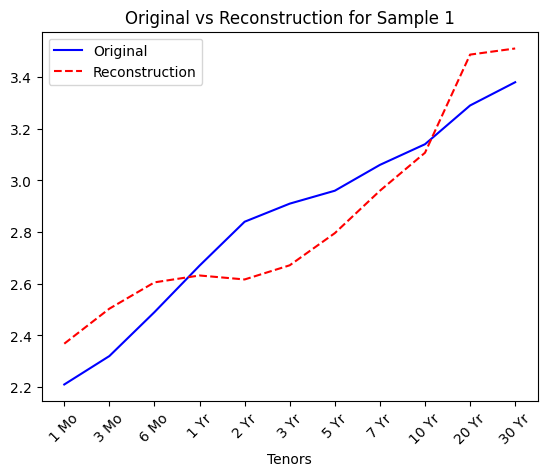

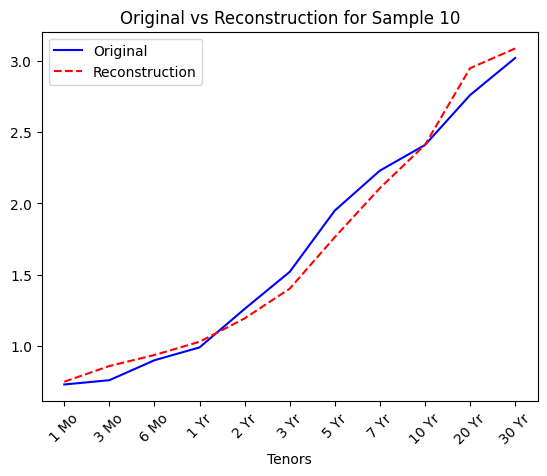

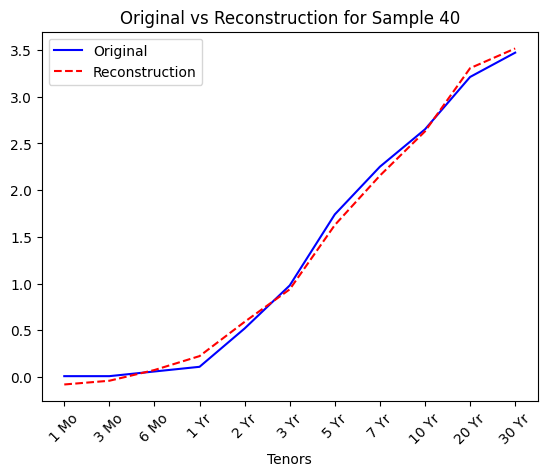

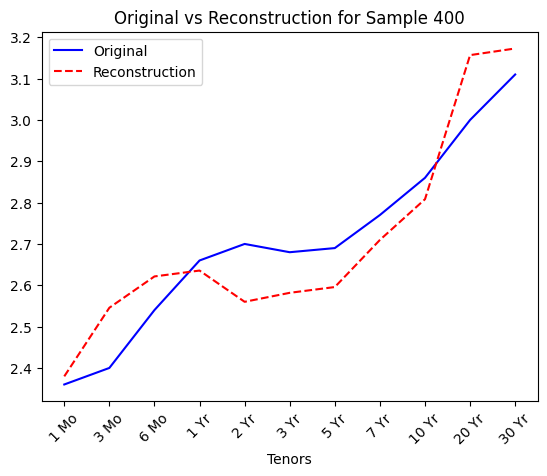

In [ ]:
plot_curve(x_test, 1)
plot_curve(x_test, 10)
plot_curve(x_test, 40)
plot_curve(x_test, 400)

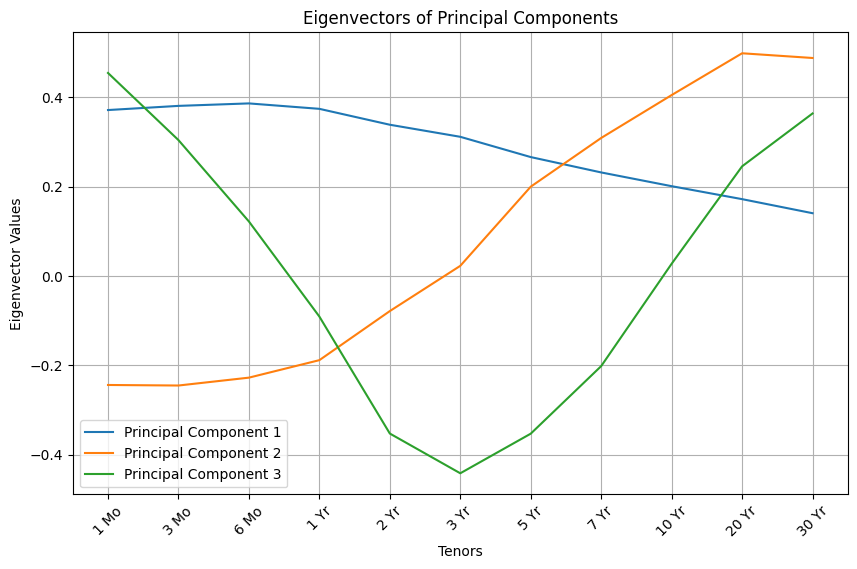

In [ ]:
# Perform PCA
pca = PCA(n_components=3)  # Reduce to 2 principal components
pca.fit(X)  # Fit PCA to the original dataset

# Extract eigenvectors (principal components)
eigenvectors = pca.components_

# Plot eigenvectors
plt.figure(figsize=(10, 6))
for i, eigenvector in enumerate(eigenvectors):
    plt.plot(eigenvector, label=f'Principal Component {i + 1}')

plt.title("Eigenvectors of Principal Components")
plt.xlabel("Tenors")
plt.xticks(ticks=range(len(tenors)), labels=tenors, rotation=45)
plt.ylabel("Eigenvector Values")
plt.legend()
plt.grid(True)
plt.show()